# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [2]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [3]:
!pip install gymnasium[toy_text]

# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize the policy __uniformly__, that is, probabililities of all actions should be equal.

# Play the game

Just like before, but we also record all states and actions we took.

In [65]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3", render_mode="rgb_array")
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")

def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions), dtype=np.float32)/n_actions

    return policy

policy = initialize_policy(n_states, n_actions)

def generate_session(env, policy, t_max=10**4, s=None, dropout=0.0, a=None, return_only_reward=False):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    if not return_only_reward:
        states, actions = [], []
    total_reward = 0.0

    if not s:
        s, _ = env.reset()

    if a:
        if not return_only_reward:
            states.append(s)
            actions.append(a)
        new_s, r, terminated, truncated, _ = env.step(a)
        total_reward += r
        s = new_s

    for t in range(t_max):

        if np.random.uniform(0, 1) < dropout:
            a = np.random.choice(range(n_actions))
        else:

            # print(s, " ", policy[s])
            a = np.random.choice(range(n_actions), p=policy[s]/policy[s].sum())


        # print(env.step(a))
        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        if not return_only_reward:
            states.append(s)
            actions.append(a)
        total_reward += r

        s = new_s
        if terminated:
            break
    if return_only_reward:
        return total_reward
    else:
        return states, actions, total_reward

def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for states, actions, reward in zip(states_batch, actions_batch, rewards_batch):
        if reward >= reward_threshold:
            elite_states.extend(states)
            elite_actions.extend(actions)

    return elite_states, elite_actions

def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for state, action in zip(elite_states, elite_actions):
        new_policy[state, action] += 1

    for state in range(n_states):
        total_occurrences = np.sum(new_policy[state])

        if total_occurrences > 0:
            new_policy[state] /= total_occurrences
        else:
            new_policy[state] = np.ones(n_actions) / n_actions

    return new_policy


from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

n_states=500, n_actions=6


In [5]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30
)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90
)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100
)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]
), "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and np.all(
    test_result_30[1] == [3, 2, 0, 1, 3, 3]
), "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and np.all(
    test_result_90[1] == [3, 3]
), "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and np.all(
    test_result_100[1] == [3, 3]
), "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")

elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy
).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0
), "Your new policy can't have negative action probabilities"
assert np.allclose(
    new_policy.sum(axis=-1), 1
), "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array(
    [
        [1.0, 0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.5, 0.0],
        [0.0, 0.33333333, 0.66666667, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.5, 0.5],
    ]
)
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")


Ok!
Ok!


# Training loop
Generate sessions, select N best and fit to those.

mean reward = 0.940, threshold=5.000


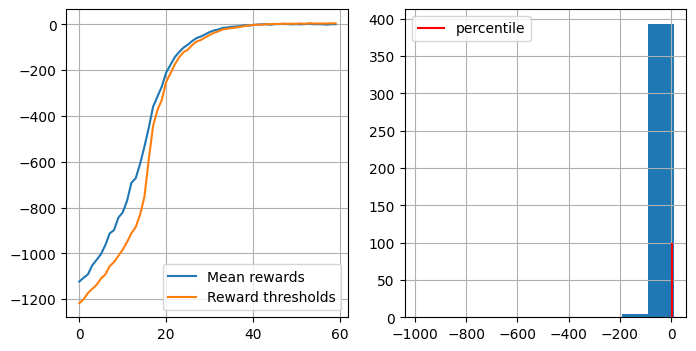

In [71]:
policy = initialize_policy(n_states, n_actions)
n_sessions = 450  # sample this many sessions
percentile = 30  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in range(0, 60):
    %time sessions = [ generate_session(env, policy, t_max=300) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    show_progress(rewards_batch, log, percentile)


mean reward = 5.888, threshold=6.000


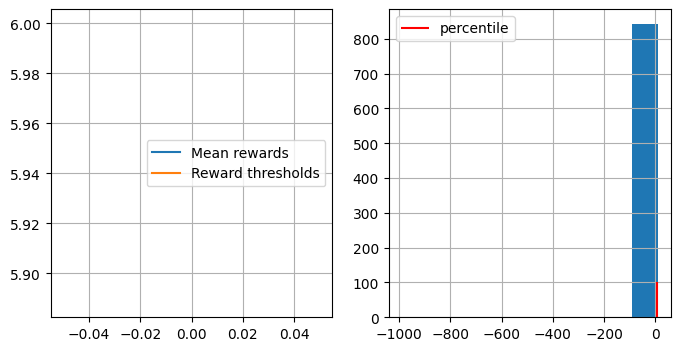

In [72]:
from scipy.special import softmax
policy_softmaxed = softmax(policy*100, axis=1)
sessions = [ generate_session(env, policy_softmaxed, t_max=100) for _ in range(1000)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
ll = []
show_progress(rewards_batch, ll, percentile)

In [49]:
from tqdm import tqdm
n_sessions = 800
percentile = 70
policy_tuned = policy_softmaxed.copy()
for dropout_state in tqdm(range(n_states)):
    policy_tuned[dropout_state] = np.ones(n_actions)/n_actions
    sessions = [ generate_session(env, policy, t_max=500) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    dropout_policy = np.ones(n_actions, dtype = np.float32)
    for state, action in zip(elite_states, elite_actions):
        if state == dropout_state:
            dropout_policy[action] += 1
    dropout_policy = softmax(dropout_policy*100)
    policy_tuned[dropout_state] = dropout_policy


100%|██████████| 500/500 [06:24<00:00,  1.30it/s]


In [52]:
policy_tuned[policy_tuned.sum(axis=1) > 1.]
# policy_tuned2 = policy_tuned /policy_tuned.sum(axis=1, keepdims=True)

array([[0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       ...,
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667],
       [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
        0.16666667]])

mean reward = -178.367, threshold=9.000


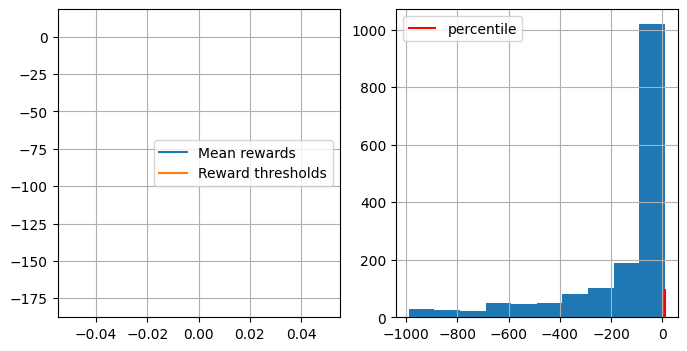

In [56]:
sessions = [ generate_session(env, policy_tuned, t_max=300) for _ in range(2000)]
states_batch, actions_batch, rewards_batch = zip(*sessions)
ll = []
show_progress(rewards_batch, ll, percentile)

In [ ]:
n_sessions = 450  # sample this many sessions
percentile = 10  # discard this percentage of sessions with lowest rewards
learning_rate = 0.3  # how quickly the policy is updated, on a scale from 0 to 1

log2 = log.copy()

for i in range(60, 100):
    %time sessions = [ generate_session(env, policy, t_max=500) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    assert np.allclose(new_policy.sum(axis=1), np.ones(n_states, dtype=np.float32))
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
    assert np.allclose(policy.sum(axis=1), np.ones(n_states, dtype=np.float32))
    # display results on chart
    show_progress(rewards_batch, log, percentile)

In [ ]:
print(states_batch[:4])
print(actions_batch[:4])
print(rewards_batch[:4])

([429], [61], [148], [14])
([1], [3], [0], [2])
(-1.0, -1.0, -1.0, -1.0)


In [66]:

import copy
from tqdm import tqdm
# env = gym.make("Taxi-v3", render_mode="rgb_array")
# policy = initialize_policy(n_states, n_actions)
n_sessions = 250  # sample this many sessions
# percentile = 70 # discard this percentage of sessions with lowest rewards
learning_rate = 0.3  # how quickly the policy is updated, on a scale from 0 to 1

log = []

# for _ in range(500):
#     start, _ = env.reset()

#     for action in range(n_actions):
#         for _ in range(10):
#             sessions = []
#             fixed_env = copy.copy(env)
#             sessions.append(generate_session(fixed_env, policy, t_max=10**3, s=start, a=action))

#     # rewbs = []
logg = []
for _ in range(20):
    for i in tqdm(range(400)):
        start, _ = env.reset()
        states = []
        actions = []
        # sessions = []
        fixed_env = copy.copy(env)
        rewards = []
        for act in range(n_actions):
            reward = 0.0
            sessions = []
            for _ in range(100):
                sessions.append(generate_session(fixed_env, policy, t_max=100, s=start, a=act, return_only_reward=False))
            states_batch, actions_batch, rewards_batch = zip(*sessions)
            # print(states_batch[:4])
            # print(actions_batch[:4])
            reward = sum(rewards_batch)
            rewards.append(reward)
            break
        break
        opt_action = rewards.index(max(rewards))
        states.append(start)
        actions.append(opt_action)
        new_policy = get_new_policy(states, actions)
        policy = learning_rate * new_policy + (1 - learning_rate) * policy
        # show_progress(rewards_batch, log, percentile)
    break
    sessions = [ generate_session(env, policy, t_max=100) for _ in range(n_sessions)]
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    show_progress(rewards_batch, logg, percentile)


  0%|          | 0/400 [00:00<?, ?it/s]

([292, 292, 292, 292, 292, 292, 292, 192, 292, 292, 272, 172, 172, 152, 152, 152, 152, 252, 252, 272, 172, 72, 72, 72, 52, 52, 52, 52, 152, 152, 152, 252, 232, 132, 112, 212, 212, 112, 12, 112, 112, 12, 12, 12, 32, 32, 32, 12, 112, 112, 112, 212, 112, 12, 12, 112, 112, 212, 212, 112, 112, 212, 212, 312, 312, 312, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 312, 212, 112, 112, 132, 132, 112, 132, 32, 12, 112], [292, 12, 12, 12, 12, 12, 112, 212, 312, 312, 312, 212, 112, 212, 212, 212, 212, 212, 312, 312, 312, 212, 212, 312, 312, 212, 212, 112, 112, 112, 12, 12, 32, 32, 132, 232, 232, 232, 332, 332, 332, 232, 332, 332, 352, 252, 232, 132, 132, 32, 32, 32, 32, 32, 12, 112, 112, 132, 112, 112, 12, 12, 32, 132, 132, 132, 112, 212, 232, 132, 132, 232, 132, 32, 32, 32, 132, 232, 232, 232, 232, 332, 332, 432, 432, 432, 332, 352, 352, 352, 352, 352, 452, 452, 352, 252, 252, 232, 212, 212], [292, 212, 312, 312, 412, 312, 412,

In [73]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo

env1 = gym.make("Taxi-v3", render_mode="rgb_array")  # Ensure correct render mode
env1 = RecordVideo(env1, video_folder="./videos4", episode_trigger=lambda x: True)

# Reset environment before use
# env1.reset()

# Generate sessions
sessions = [generate_session(env1, policy_softmaxed, 200) for _ in range(10)]

env1.close()  # Ensure proper closing


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


In [ ]:
table

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:
import gym
import numpy
import random
from os import system, name
from time import sleep
from scipy.special import softmax

# env = gym.make("Taxi-v3", render_mode="rgb_array")

# Matrix filled with zeros.
# The matrix will be 500x6 as there are 500 states and 6 actions.
q_table = numpy.zeros([env.observation_space.n, env.action_space.n])

training_episodes = 20000 # Amount of times to run environment while training.
display_episodes = 10 # Amount of times to run environment after training.

# Hyperparameters
alpha = 0.1 # Learning Rate
gamma = 0.6 # Discount Rate
epsilon = 0.1 # Chance of selecting a random action instead of maximising reward.

# For plotting metrics
all_epochs = []
all_penalties = []


logg = []


# env3 = gym.make("Taxi-v3", render_mode="rgb_array")


for i in range(training_episodes):
    state, _ = env.reset()
    done = False
    penalties, reward, = 0, 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = numpy.argmax(q_table[state])

        next_state, reward, done, info = env.step(action)

        old_value = q_table[state, action]
        next_max = numpy.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state

    if i % 100 == 0:
        pass
        # print(f"Episode: {i}")
    if i % 400 == 0:
        ids = q_table.argmax(axis=1)
        table = np.zeros_like(q_table)
        for i in range(table.shape[0]):
            table[i][ids[i]] = 1.0

        sessions = [ generate_session(env, table, t_max=100) for _ in range(300)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)
        show_progress(rewards_batch, logg, percentile)

# new_policy = softmax(policy*10, axis=1)
# q_table




print("Training finished.\n")





print(states_batch)

### Reflecting on results

You may have noticed that the taxi problem quickly converges from less than -1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or change the way you evaluate strategy (theoretically correct way). For each starting state, you can sample an action randomly, and then evaluate this action by running _several_ games starting from it and averaging the total reward. Choosing elite sessions with this kind of sampling (where each session's reward is counted as the average of the rewards of all sessions with the same starting state and action) should improve the performance of your policy.


### You're not done yet!

Go to [`./deep_crossentropy_method.ipynb`](./deep_crossentropy_method.ipynb) for a more serious task